In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [3]:
batch_size = 32
img_height = 160
img_width = 160

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [8]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1)
])

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\github\python\lecture\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
initial_epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs
)

Epoch 1/10
50/50 [==============================] - 22s 243ms/step - loss: 0.5522 - accuracy: 0.6625 - val_loss: 0.4610 - val_accuracy: 0.7475
Epoch 2/10
50/50 [==============================] - 11s 227ms/step - loss: 0.3995 - accuracy: 0.7894 - val_loss: 0.3469 - val_accuracy: 0.8525
Epoch 3/10
50/50 [==============================] - 11s 227ms/step - loss: 0.3103 - accuracy: 0.8594 - val_loss: 0.2796 - val_accuracy: 0.8963
Epoch 4/10
50/50 [==============================] - 11s 227ms/step - loss: 0.2566 - accuracy: 0.9000 - val_loss: 0.2365 - val_accuracy: 0.9200
Epoch 5/10
50/50 [==============================] - 11s 227ms/step - loss: 0.2202 - accuracy: 0.9156 - val_loss: 0.2075 - val_accuracy: 0.9312
Epoch 6/10
50/50 [==============================] - 9s 181ms/step - loss: 0.1949 - accuracy: 0.9231 - val_loss: 0.1865 - val_accuracy: 0.9400
Epoch 7/10
50/50 [==============================] - 11s 227ms/step - loss: 0.1762 - accuracy: 0.9369 - val_loss: 0.1707 - val_accuracy: 0.9475


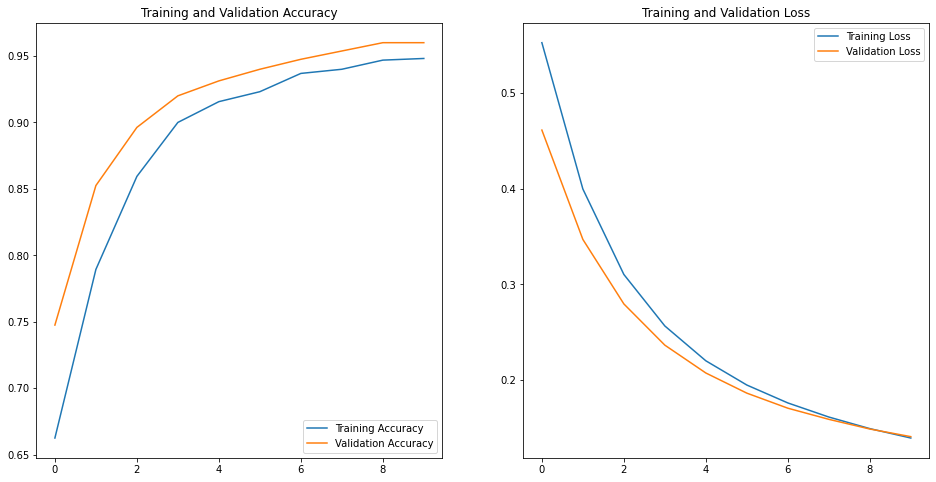

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
base_model.trainable = True

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [18]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
50/50 [==============================] - 19s 268ms/step - loss: 0.3736 - accuracy: 0.8650 - val_loss: 0.1140 - val_accuracy: 0.9638
Epoch 11/20
50/50 [==============================] - 13s 254ms/step - loss: 0.1957 - accuracy: 0.9519 - val_loss: 0.1088 - val_accuracy: 0.9675
Epoch 12/20
50/50 [==============================] - 13s 254ms/step - loss: 0.1324 - accuracy: 0.9656 - val_loss: 0.1007 - val_accuracy: 0.9675
Epoch 13/20
50/50 [==============================] - 13s 254ms/step - loss: 0.0969 - accuracy: 0.9769 - val_loss: 0.0959 - val_accuracy: 0.9688
Epoch 14/20
50/50 [==============================] - 13s 254ms/step - loss: 0.0739 - accuracy: 0.9819 - val_loss: 0.0906 - val_accuracy: 0.9700
Epoch 15/20
50/50 [==============================] - 13s 254ms/step - loss: 0.0577 - accuracy: 0.9925 - val_loss: 0.0874 - val_accuracy: 0.9700
Epoch 16/20
50/50 [==============================] - 10s 209ms/step - loss: 0.0456 - accuracy: 0.9956 - val_loss: 0.0843 - val_accuracy:

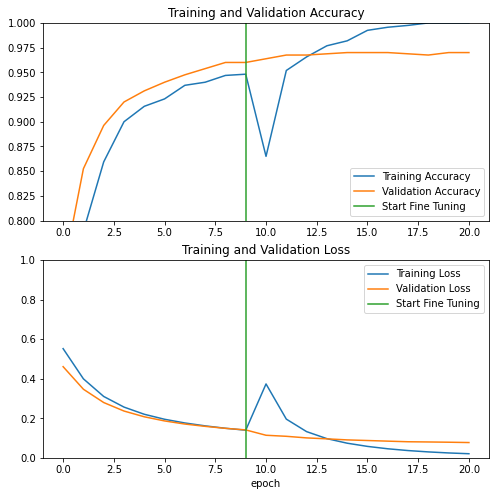

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()